Question9 - Rice_Grain_Counting

In [7]:
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

images = {
    "8a": "../data/a1images/rice.png",  # Figure 8a
    "8b": "../data/a1images/Salt_and_pepper_noise_corrected.png"  # Figure 8b
}

output_dir = "../data/output_images"
os.makedirs(output_dir, exist_ok=True)

Rice grain count for Fig 8a: 79


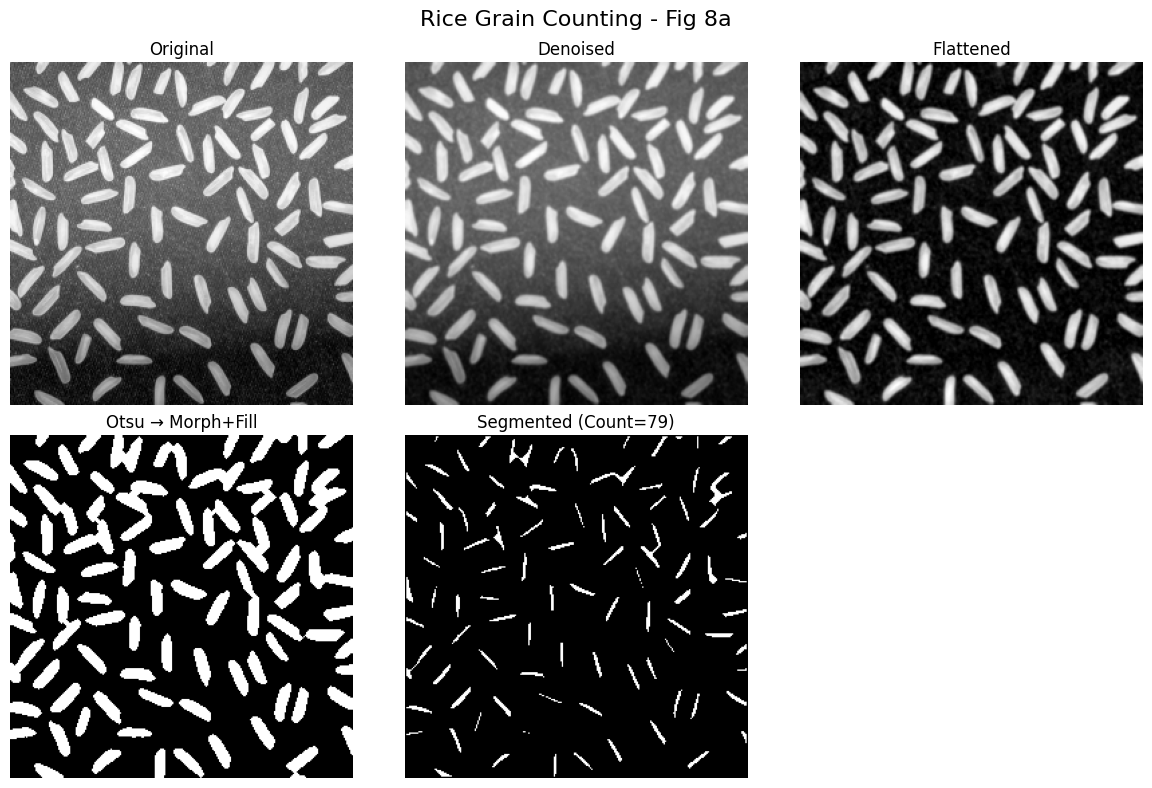

Rice grain count for Fig 8b: 77


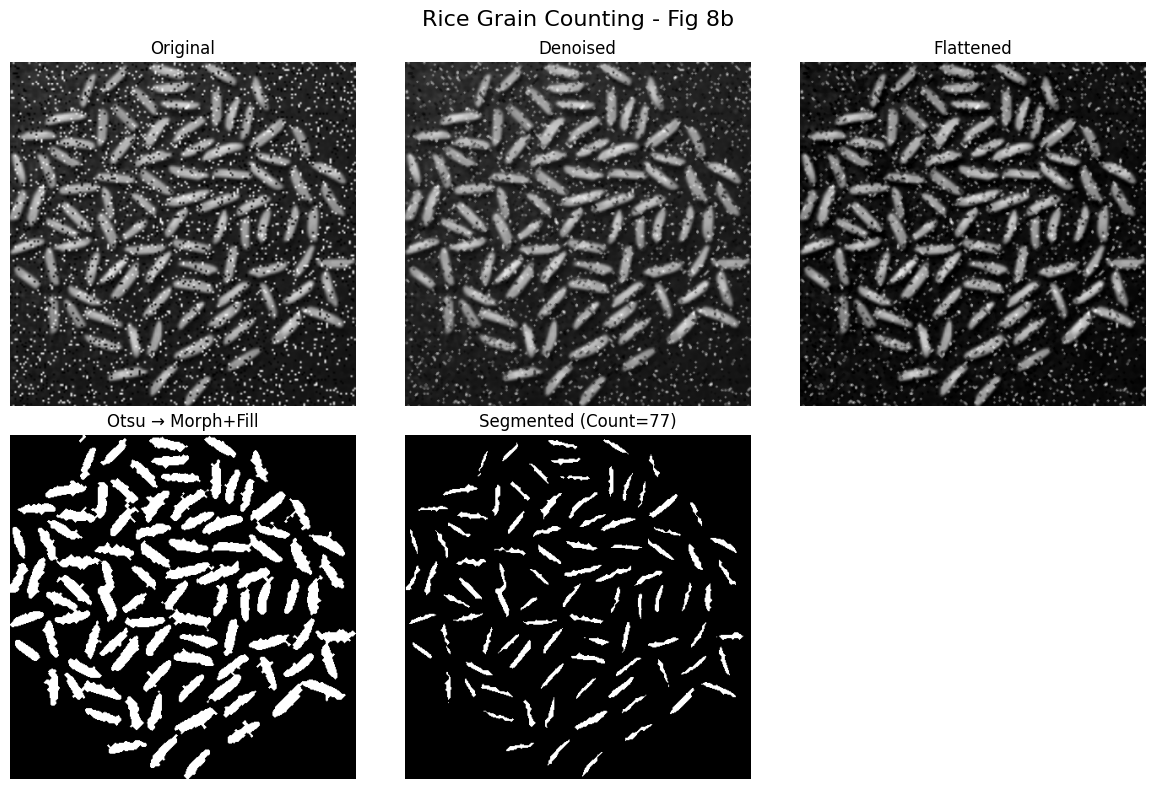

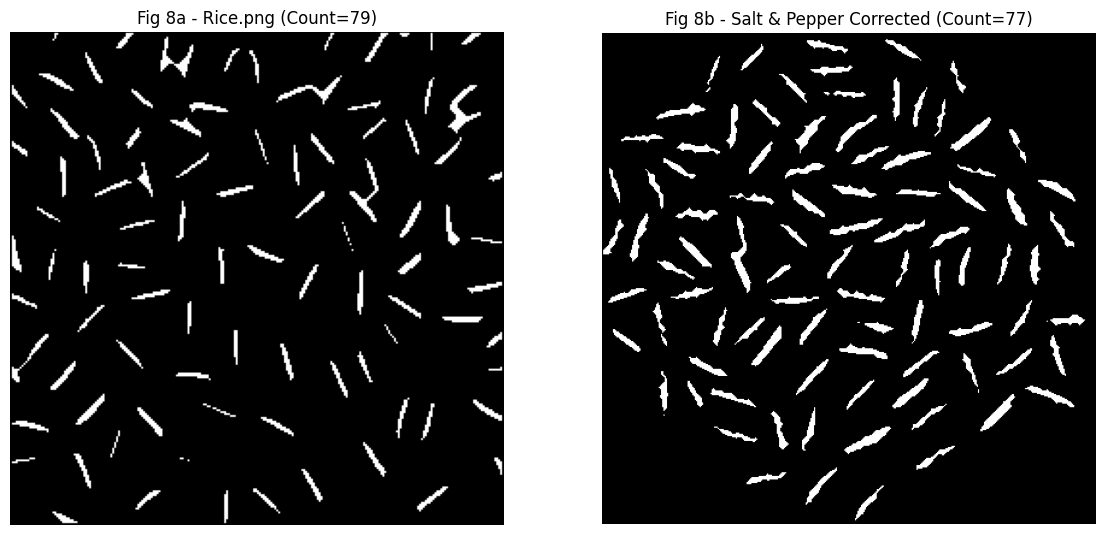

In [8]:
# Function to fill holes
def fill_holes(bin255):
    inv = cv2.bitwise_not(bin255)
    h, w = inv.shape
    ffmask = np.zeros((h+2, w+2), np.uint8)
    flood = inv.copy()
    cv2.floodFill(flood, ffmask, (0,0), 255)
    holes = cv2.bitwise_not(flood)
    return cv2.bitwise_or(bin255, holes)

# Store final outputs for side-by-side visualization
final_segmented_images = {}
final_counts = {}

# Process each image
for suffix, path in images.items():
    g = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if g is None:
        raise FileNotFoundError(path)

    # Denoising
    if suffix == "8a":
        g_d = cv2.GaussianBlur(g, (3,3), 0.8)
    else:
        g_d = cv2.medianBlur(g, 3)

    cv2.imwrite(f"{output_dir}/rice_{suffix}_denoised.png", g_d)

    # Background flattening
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31,31))
    bg = cv2.morphologyEx(g_d, cv2.MORPH_OPEN, k)
    flat = cv2.subtract(g_d, bg)
    flat = cv2.normalize(flat, None, 0, 255, cv2.NORM_MINMAX)
    cv2.imwrite(f"{output_dir}/rice_{suffix}_flattened.png", flat)

    # Otsu threshold
    _, th_raw = cv2.threshold(flat, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if np.mean(flat[th_raw>0]) < np.mean(flat[th_raw==0]):
        th_raw = cv2.bitwise_not(th_raw)
    cv2.imwrite(f"{output_dir}/rice_{suffix}_mask.png", th_raw)

    # Morphology
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    mask = cv2.morphologyEx(th_raw, cv2.MORPH_OPEN, se, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, se, iterations=2)

    # Remove tiny objects
    num, lab = cv2.connectedComponents(mask)
    areas = np.bincount(lab.ravel())
    keep = np.ones(num, np.uint8)
    keep[0] = 0
    minA, maxA = 30, 10000
    for i, a in enumerate(areas):
        if i==0: continue
        if a < minA or a > maxA: keep[i] = 0
    mask = (keep[lab]*255).astype(np.uint8)

    # Fill holes
    mask_filled = fill_holes(mask)
    cv2.imwrite(f"{output_dir}/rice_{suffix}_filled_mask.png", mask_filled)

    # Connected Components / Count 
    n_final, lab_final = cv2.connectedComponents((mask_filled>0).astype(np.uint8))
    count = n_final-1  # exclude background
    print(f"Rice grain count for Fig {suffix}: {count}")
    final_counts[suffix] = count

    # Watershed (optional)
    bin8 = (mask_filled>0).astype(np.uint8)
    dist = cv2.distanceTransform(bin8, cv2.DIST_L2, 5)
    markers = (dist > 0.45*dist.max()).astype(np.uint8)
    _, markers = cv2.connectedComponents(markers)
    markers = markers + 1
    markers[bin8==0] = 0
    rgb_for_ws = cv2.cvtColor(g, cv2.COLOR_GRAY2RGB)
    ws = cv2.watershed(rgb_for_ws.copy(), markers.astype(np.int32))
    seg = (ws>1).astype(np.uint8)*255
    cv2.imwrite(f"{output_dir}/rice_{suffix}_segmented.png", seg)

    # Overlay 
    overlay = rgb_for_ws.copy()
    overlay[mask_filled==0] = (overlay[mask_filled==0]*0.25).astype(np.uint8)
    cv2.imwrite(f"{output_dir}/rice_{suffix}_overlay.png", overlay)
    cv2.imwrite(f"{output_dir}/rice_{suffix}_original_vs_segmented.png",
                cv2.cvtColor(np.hstack([rgb_for_ws, cv2.cvtColor(seg, cv2.COLOR_GRAY2RGB)]), cv2.COLOR_RGB2BGR))

    # Save for side-by-side visualization 
    final_segmented_images[suffix] = cv2.cvtColor(seg, cv2.COLOR_GRAY2RGB)

    # Display 6-panel figure 
    plt.figure(figsize=(12,8))
    plt.suptitle(f"Rice Grain Counting - Fig {suffix}", fontsize=16)
    plt.subplot(2,3,1); plt.title("Original"); plt.imshow(g, cmap="gray"); plt.axis("off")
    plt.subplot(2,3,2); plt.title("Denoised"); plt.imshow(g_d, cmap="gray"); plt.axis("off")
    plt.subplot(2,3,3); plt.title("Flattened"); plt.imshow(flat, cmap="gray"); plt.axis("off")
    plt.subplot(2,3,4); plt.title("Otsu → Morph+Fill"); plt.imshow(mask_filled, cmap="gray"); plt.axis("off")
    plt.subplot(2,3,5); plt.title(f"Segmented (Count={count})"); plt.imshow(seg, cmap="gray"); plt.axis("off")
    #plt.subplot(2,3,6); plt.title("Original vs Segmented"); plt.imshow(np.hstack([rgb_for_ws, seg])); plt.axis("off")
    plt.tight_layout()
    plt.show()

# Visualize both Fig 8a and 8b side-by-side
seg_8a = final_segmented_images["8a"]
seg_8b = final_segmented_images["8b"]

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title(f"Fig 8a - Rice.png (Count={final_counts['8a']})")
plt.imshow(seg_8a)
plt.axis("off")

plt.subplot(1,2,2)
plt.title(f"Fig 8b - Salt & Pepper Corrected (Count={final_counts['8b']})")
plt.imshow(seg_8b)
plt.axis("off")
plt.show()

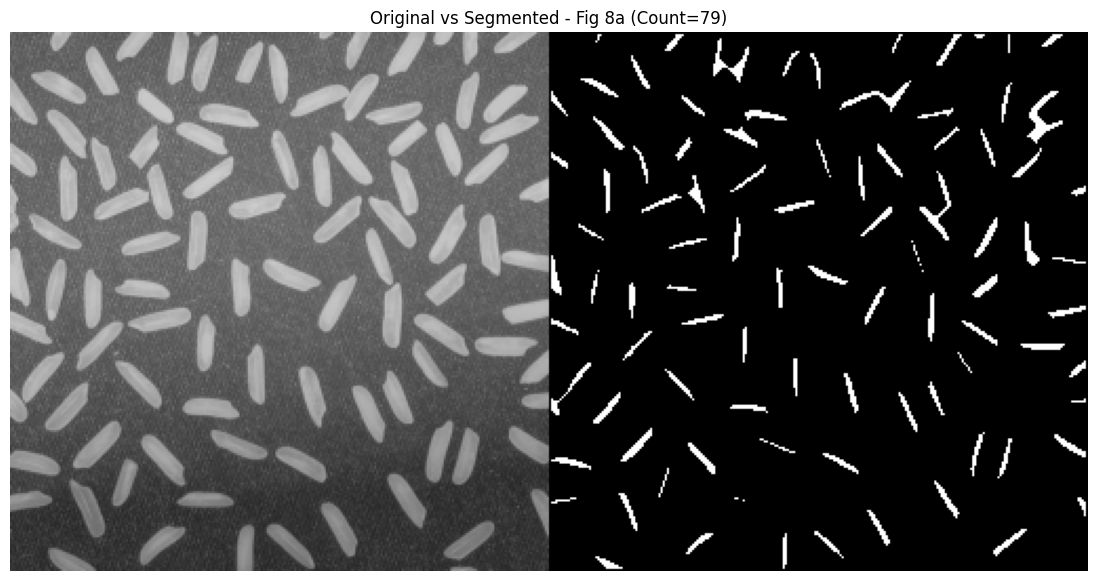

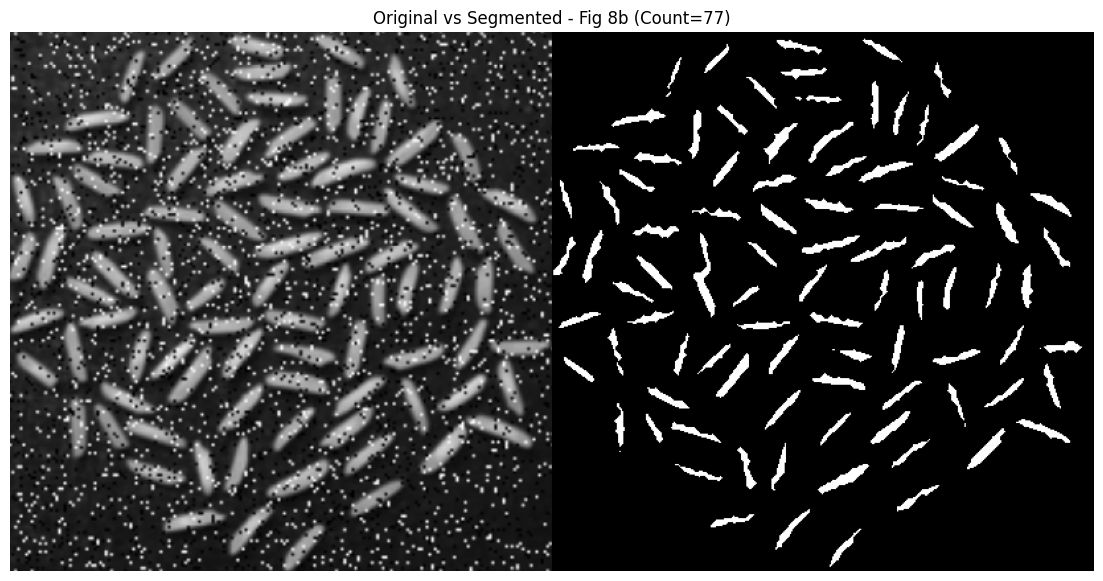

In [9]:
# Original vs Segmented Side-by-Side for Each Image 

for suffix in ["8a", "8b"]:
    # Load the original grayscale image and RGB version
    if suffix == "8a":
        g_orig = cv2.imread("../data/a1images/rice.png", cv2.IMREAD_GRAYSCALE)
    else:
        g_orig = cv2.imread("../data/a1images/Salt_and_pepper_noise_corrected.png", cv2.IMREAD_GRAYSCALE)

    rgb_orig = cv2.cvtColor(g_orig, cv2.COLOR_GRAY2RGB)

    # Get the final segmented image from your processed results
    seg_img = final_segmented_images[suffix]

    # Convert segmentation to RGB if needed (just in case)
    if len(seg_img.shape) == 2:
        seg_img_rgb = cv2.cvtColor(seg_img, cv2.COLOR_GRAY2RGB)
    else:
        seg_img_rgb = seg_img.copy()

    # Stack original and segmented horizontally
    combined = np.hstack([rgb_orig, seg_img_rgb])

    # Display
    plt.figure(figsize=(14,7))
    plt.title(f"Original vs Segmented - Fig {suffix} (Count={final_counts[suffix]})")
    plt.imshow(combined)
    plt.axis("off")
    plt.show()
